# 1. Import necessary library and data  
This colab notebook uses Flickr 8k dataset and .txt files that contain filepath to each kind of dataset (i.e. train, validate, test) which you can download from [here](https://drive.google.com/file/d/1Jr9K1L-grIC5UQjff4UPN5A29aJL86cn/view?usp=sharing)  

This dataset contains 8000 images with 5 captions each. These images are divided as follow:  
* Training set: 6000 images
* Validate set: 1000 images
* Test set: 1000 images

In [ ]:
import os
import random
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pickle import dump, load
from tqdm.notebook import tqdm
from PIL import Image
from keras.preprocessing import sequence
from keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model, Sequential, Model
from keras.layers import Input, LSTM, Embedding, Dense, Dropout
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Colab_data/image_captioning_dataset/image_captioning.zip -d /content/data

# 2. Load data  

The file "Flickr8k.token.txt" contains the name of each image along with its 5 captions. We can read this file as below  
As you can see, every line contains the <image name\>#i <caption\> (0 <= i <= 4)

In [ ]:
# Read caption file
def load_doc(filename):
    # Open file name as read only
    file = open(filename, 'r')

    # Read all text
    text = file.read()
    file.close()

    return text

filename = '/content/data/Flickr8k/Flickr8k_text/Flickr8k.token.txt'
doc = load_doc(filename)
print(doc[:300])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


Now we create a dictionary named "descriptions" which contains the **name of the image** (without the .jpg postfix) as keys and a **list of 5 captions** as values

In [ ]:
# Save caption key - value
def load_description(doc):
    mapping = dict()
    for line in doc.split('\n'):
        # Split by white space
        tokens = line.split()

        # When finish reading
        if len(line) < 2:
            continue

        # Take first token as image id, rest as the description
        image_id, image_desc = tokens[0], tokens[1:]

        # Extract filename from image id
        image_id = image_id.split('.')[0]

        # Convert description tokens back to string
        image_desc = ' '.join(image_desc)

        # Create the list (in case a picture having multiple captions)
        if image_id not in mapping:
            mapping[image_id] = list()

        # Store description
        mapping[image_id].append(image_desc)
    
    return mapping

descriptions = load_description(doc)
print('Loaded: ' + str(len(descriptions)))

Loaded: 8092


In [ ]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

# 3. Data cleaning  
After dealing with text, we generally **clean the data**. Some tasks like:
* Lower-case all the words (Hello -> hello)
* Remove punctuation 
* Remove hanging character 
* Remove special tokens
* Remove texts containing numbers

In [ ]:
# Preprocessing text
def clean_descriptions(descriptions):
    # Removing punctuation table
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            desc = desc.split()
            # Lower words
            desc = [word.lower() for word in desc]
            # Remove punctuation
            desc = [w.translate(table) for w in desc]
            # Remove hanging character
            desc = [w for w in desc if len(w) > 1]
            # Remove tokens with numbers in them
            desc = [w for w in desc if w.isalpha()]
            # Store as string
            desc_list[i] = ' '.join(desc)

clean_descriptions(descriptions)

In [ ]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

**Save** all these cleaned captions along with their image names in new file "descriptions.txt"

In [ ]:
# Save descriptions
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

save_descriptions(descriptions, '/content/data/descriptions.txt')

# 4. Loading the training set  
The text file “Flickr_8k.trainImages.txt” contains the names of the images that belong to the training set. So we **load these names into a list “train"**

In [ ]:
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    for line in doc.split('\n'):
        # When finish reading
        if len(line) < 2:
            continue
        # Get image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

# Load training dataset
filename = '/content/data/Flickr8k/Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset:', len(train))

Dataset: 6000


Load names of images into "train_img" and "test_img" for later use

In [ ]:
images_path = '/content/data/Flickr8k/Flicker8k_Dataset'
img = os.listdir(images_path)

In [ ]:
def get_img(path):
    # Read images name
    imgs = set(open(path, 'r').read().split('\n'))

    ret_img = []
    # Add images
    for filepath in img:
        if filepath in imgs:
            ret_img.append(filepath)

    return ret_img

# File path
train_path = '/content/data/Flickr8k/Flickr8k_text/Flickr_8k.trainImages.txt'
test_path = '/content/data/Flickr8k/Flickr8k_text/Flickr_8k.testImages.txt'

train_img = get_img(train_path)
test_img = get_img(test_path)

print('Length of training - validation - testing dataset: {} - {}'.format(len(train_img), len(test_img)))

Add tokens in 2 ends of each caption (for training) as follow:
- '**startseq**': This is a start sequence token added at the start of every captions
- '**endseq**': This is an end sequence token added at the end of every captions

After adding tokens, store captions in dictionary "**train_descriptions**"

In [ ]:
# Add 'startseq', 'endseq' at head and last of string
def load_clean_descriptions(filename, dataset):
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        img_id, img_desc = tokens[0], tokens[1:]
        if img_id in dataset:
            if img_id not in descriptions:
                descriptions[img_id] = list()

            # Wrap description in tokens
            desc = 'startseq ' + ' '.join(img_desc) + ' endseq'
            descriptions[img_id].append(desc)
    return descriptions

train_descriptions = load_clean_descriptions('/content/data/descriptions.txt', train)
print('Description:', len(train_descriptions))

Description: 6000


# 5. Data preprocessing  
At this step, we preprocess captions and images which are the input of our training model.

## 5.1. Preprocessing Images  
We need to convert every images into a fixed sized vector which can then be fed as input to the NN. For this purpose, we use **transfer learning** by using the InceptionV3 model created by Google Teams (you can read and practice in [here](https://paperswithcode.com/method/inception-v3)). The model was trained on Imagenet dataset to perform image classification on 1000 different classes of images.

The cell below here preprocess input into array with fixed size that fit model input

In [ ]:
# Load and resize images to fit INceptionV3's input size
def preprocess(image_path):
    # Convert to desired size
    img = load_img(image_path, target_size=(299, 299))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    # Preprocess images using function from inception module
    img = preprocess_input(img)
    
    return img

In [ ]:
# Load InceptionV3 model
model = InceptionV3(weights='imagenet')

96124928/96112376 [==============================] - 1s 0us/step


Here we remove the last softmax layer from the model and extract a (2048,) vector for every image  
The illustrator for this process:
![images](https://i.imgur.com/04UBVKS.png)

In [ ]:
# Remove last layer of InceptionV3
model_new = Model(inputs=model.input, outputs=model.layers[-2].output)

Now we pass every images to this model to get the corresponding feature size of (2048,)

In [ ]:
# Image embedding to vector (2048,)
def encode(image):
    # Preprocess image
    image = preprocess(image)
    # Get the encoding vector 
    fea_vec = model_new.predict(image)
    # Reshape from (1, 2048) to (2048,)
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    
    return fea_vec

In [ ]:
def encoding_images(imgs):
    encoding_img = {}

    for path in tqdm(imgs):
        encoding_img[path] = encode(images_path + '/' + path)

    return encoding_img

encoding_train = encoding_images(train_img)
encoding_test = encoding_images(test_img)

Save all features in a dictionary and save it as Pickle file, namely "**encoding_train**" and "**encoding_test**"

In [ ]:
# Create folder
folder = '/content/data/Flickr8k/Pickle/'
if not os.path.exists(folder):
    os.mkdir(folder)

# Save image embedding
with open('/content/data/Flickr8k/Pickle/encoded_train_images.pkl', 'wb') as encoded_pickle:
    dump(encoding_train, encoded_pickle)

# Save image embedding
with open('/content/data/Flickr8k/Pickle/encoded_test_images.pkl', 'wb') as encoded_pickle:
    dump(encoding_test, encoded_pickle)

## 5.2. Preprocessing Captions  
As we predict the caption **word by word**, we need to encode each word into a fixed size vector

The first step is loading the captions into a list "**train_captions**"

In [ ]:
# Create list of training captions
train_captions = []
for key, val in train_descriptions.items():
    # As 1 picture can have more than 1 caption
    for cap in val:
        train_captions.append(cap)

print(len(train_captions))

30000


We don't want to take words that rarely appear in our 30,000 sized dataset. So we only take words that appear no smaller than 10 times.

In [ ]:
# Take words appearing more than 10 times
word_count_threshold = 10
word_count = {}
for cap in train_captions:
    for w in cap.split(' '):
        # Increase number of word counted
        word_count[w] = word_count.get(w, 0) + 1

vocab = [w for w in word_count if word_count[w] >= word_count_threshold]
print('preprocess words {} -> {}'.format(len(word_count), len(vocab)))

preprocess words 7578 -> 1651


A dictionary that keeps words' indice and vice versa

In [ ]:
# Save word's index
idx_to_word = {}
word_to_idx = {}
idx = 1

for w in vocab:
    idx_to_word[idx] = w
    word_to_idx[w] = idx
    idx += 1

Not only images' array need to be converted into a fixed sized vector, but also our captions' array. As the length of each sequence are different, we need to pad these so that their length will be equal to the longest sequence. Therefore, we add 1 to our "**vocab_size**"

In [ ]:
# Add padding word
vocab_size = len(idx_to_word) + 1

Calculate the maximum length of a caption

In [ ]:
# Convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    desc = list()
    for key in descriptions.keys():
        [desc.append(d) for d in descriptions[key]]
    return desc

# Calculate the length of the longest description
def max_length(descriptions):
    lines = to_lines(descriptions)
    max_length = 0
    for sen in lines:
        length = len(sen.split())
        if (length > max_length):
            max_length = length
    return max_length

max_length = max_length(train_descriptions)
print('Longest description length: ', max_length)

Longest description length:  34


# 6. Data Preparation using Generator Function  
Before continue following the code, I highly recommend you check out [this blog](https://towardsdatascience.com/image-captioning-with-keras-teaching-computers-to-describe-pictures-c88a46a311b8) to have a gasp of what is going on at this step.

In [ ]:
# data generator for training
def data_generator(descriptions, photos, word_to_idx, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n = 0
    # Loop for ever over images
    while True:
        for key, desc_list in descriptions.items():
            n += 1
            # Retrieve photo's features
            photo = photos[key + '.jpg']
            for desc in desc_list:
                # Encode the sequence
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                # Split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # Split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # Pad input sequence to same length
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # Encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # Yield the batch data
            if n == num_photos_per_batch:
                yield [np.array(X1), np.array(X2)], np.array(y)
                X1, X2, y = list(), list(), list()
                n = 0

# 7. Word Embeddings
Pre-trained GloVe model is used for word embedding (size: (200,)). We just need to load it from .txt file

In [ ]:
# Load GloVe model
embedding_index = {}
f = open('/content/data/glove.6B/glove.6B.200d.txt', encoding='utf-8')

for line in tqdm(f):
    values = line.split()
    word = values[0]
    co_effs = np.asarray(values[1:], dtype='float32')
    embedding_index[word] = co_effs

f.close()
print('Found {} word vectors'.format(len(embedding_index)))


Found 400000 word vectors


In [ ]:
embedding_index['the']

array([-7.1549e-02,  9.3459e-02,  2.3738e-02, -9.0339e-02,  5.6123e-02,
        3.2547e-01, -3.9796e-01, -9.2139e-02,  6.1181e-02, -1.8950e-01,
        1.3061e-01,  1.4349e-01,  1.1479e-02,  3.8158e-01,  5.4030e-01,
       -1.4088e-01,  2.4315e-01,  2.3036e-01, -5.5339e-01,  4.8154e-02,
        4.5662e-01,  3.2338e+00,  2.0199e-02,  4.9019e-02, -1.4132e-02,
        7.6017e-02, -1.1527e-01,  2.0060e-01, -7.7657e-02,  2.4328e-01,
        1.6368e-01, -3.4118e-01, -6.6070e-02,  1.0152e-01,  3.8232e-02,
       -1.7668e-01, -8.8153e-01, -3.3895e-01, -3.5481e-02, -5.5095e-01,
       -1.6899e-02, -4.3982e-01,  3.9004e-02,  4.0447e-01, -2.5880e-01,
        6.4594e-01,  2.6641e-01,  2.8009e-01, -2.4625e-02,  6.3302e-01,
       -3.1700e-01,  1.0271e-01,  3.0886e-01,  9.7792e-02, -3.8227e-01,
        8.6552e-02,  4.7075e-02,  2.3511e-01, -3.2127e-01, -2.8538e-01,
        1.6670e-01, -4.9707e-03, -6.2714e-01, -2.4904e-01,  2.9713e-01,
        1.4379e-01, -1.2325e-01, -5.8178e-02, -1.0290e-03, -8.21

For all the 1652 unique words in our vocabulary, we create an embedding matrix which will be loaded into the model for training  
To understand more about **word embeddings**, please check out this [link](https://www.youtube.com/watch?v=pO_6Jk0QtKw). This man has an incredible way to explain stuff.

In [ ]:
# Get dimension of embedding
embedding_dims = embedding_index['the'].shape[0]

# Get 200-dim dense vector for each of the 10000 words in vocab
embedding_matrix = np.zeros(shape=(vocab_size, embedding_dims))

for word, idx in word_to_idx.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[idx] = embedding_vector

In [ ]:
embedding_matrix.shape

(1652, 200)

# 8. Define Model

In [ ]:
# Create model
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dims, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)

outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 200)      330400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

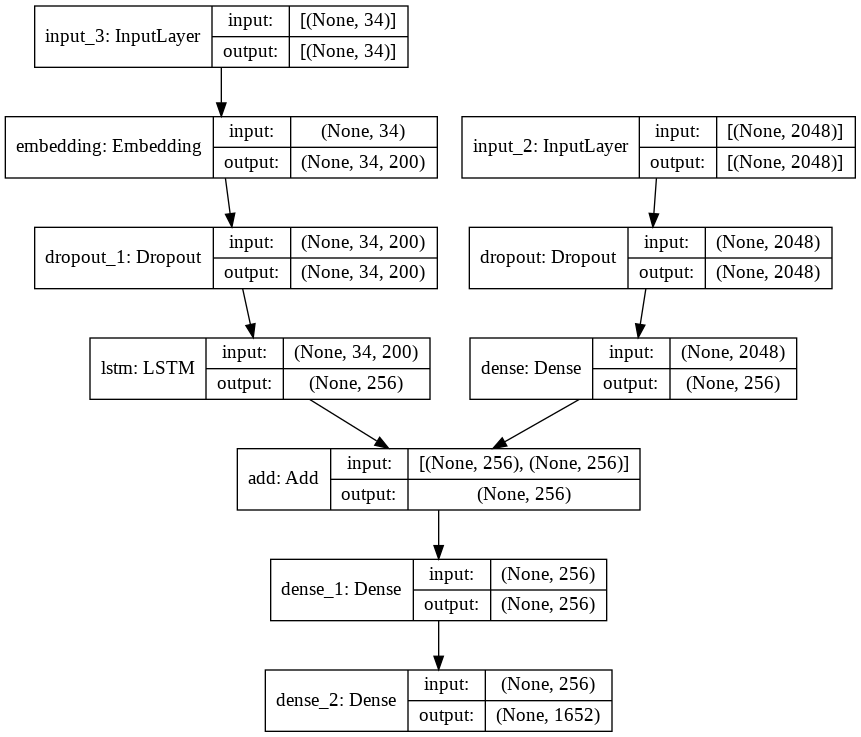

In [ ]:
# Plot model
img_model_path = '/content/drive/MyDrive/plot.png'
plot_model(model, to_file=img_model_path, show_shapes=True)

Recall that we had created an embedding matrix from a pre-train GloVe model, so we don't need to train the Embedding layer anymore.

In [ ]:
# Layer 2 uses GloVe model so we don't need to train it
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

Here we define some hyper-parameter for training

In [ ]:
model.optimizer.lr = 0.0001
epochs = 15
number_pics_per_batch = 6
steps = len(train_descriptions) // number_pics_per_batch

# 8. Training  
Train this way as it will cost us much less GPU resource than regular **fit()** function.

In [ ]:
for i in range(epochs): 
    generator = data_generator(train_descriptions, encoding_train, word_to_idx, max_length, number_pics_per_batch)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('/content/drive/MyDrive/models/model_' + str(i) + '.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


1000/1000 [==============================] - 164s 148ms/step - loss: 5.5680


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


1000/1000 [==============================] - 148s 148ms/step - loss: 3.1815


# 9. Testing on test dataset

Load model having best result

In [ ]:
best_model = load_model('/content/drive/MyDrive/models/model_14.h5')

In [ ]:
with open('/content/data/Flickr8k/Pickle/encoded_test_images.pkl', 'rb') as encoded_pickle:
    encoding_test = load(encoded_pickle)

As the model generates a 1652-long vector, which is a probability distribution across all the words in the vocabulary. For this reason, we **greedily** select the word with the maximum probability, given the feature vector and partial caption.  
This image describes this step:
![images](https://miro.medium.com/max/2000/1*isNHnFwkJQFcX3yEy2iTDg.jpeg)  
This is called as **Maximum Likelihood Estimation (MLE)** i.e. we select that word which is most likely according to the model for the given input. And sometimes this method is called as **Greedy Search**, as we greedily select the word with maximum probability.

In [ ]:
def greedy_search(photo):
    start = 'startseq'
    end = 'endseq'
    for i in range(max_length):
        sequence = [word_to_idx[w] for w in start.split() if w in word_to_idx]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = best_model.predict([photo, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word[yhat]
        start += ' ' + word
        if word == end:
            break
    
    final = start.split()
    # Remove startseq and endseq token
    final = final[1:-1]
    final = ' '.join(final)
    return final

Let's test it

man in red shirt is standing on the edge of snowy mountain


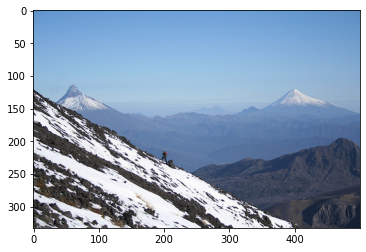

In [ ]:
z = random.randint(0, len(encoding_test))
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1, 2048))
x = plt.imread(images_path + '/' + pic)
plt.imshow(x)
print(greedy_search(image))